In [8]:
#Import Dependancies, Python SQL toolkit, and Object Relational Mapper
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [9]:
#Import Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)
# Import Inspector to Inspector Gadget the database
from sqlalchemy import inspect
Inspector = inspect(engine)

# Obtain table names
Inspector.get_table_names()

['measurement', 'station']

In [10]:
# Obtain column names for each table

MColumns = Inspector.get_columns('measurement')
print("Information for *Measurement* Table")
for C in MColumns:
    print(C['name'], C["type"])

Information for *Measurement* Table
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
SColumns = Inspector.get_columns('station')
print("Information for *Station* Table")
for C in SColumns:
    print(C['name'], C["type"])

Information for *Station* Table
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# In order to retrieve a years worth of data, query out the total scope of time.
Measures = session.query(Measurement.prcp, Measurement.date).order_by(Measurement.date.desc())


SELECT measurement.prcp AS measurement_prcp, measurement.date AS measurement_date 
FROM measurement ORDER BY measurement.date DESC


In [13]:
# Find the last recorded date by calling the first date in descending list (Last First)
Last = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Latest Date Is: {Last[0]}")

Latest Date Is: 2017-08-23


In [18]:
# Now we have the latest date, we can create a query to grab the last 12 months in the data set

#Create a list to hold the date
RainList = []

#Grab the 12 month data and append into the list; here I used the 'greater than' method.
RainGame = Measures.filter(Measurement.date >= '2016-08-23')
for R in RainGame:
    RainList.append(R)
print(RainList[:10])

[(0.0, '2017-08-23'), (0.0, '2017-08-23'), (0.08, '2017-08-23'), (0.45, '2017-08-23'), (0.0, '2017-08-22'), (0.0, '2017-08-22'), (0.5, '2017-08-22'), (0.0, '2017-08-21'), (0.02, '2017-08-21'), (None, '2017-08-21')]


In [22]:
# Save into PDF with DATE set as its Index

RainFrame = pd.DataFrame(RainList, columns=['Precipitation', 'Date'])
RainFrame = RainFrame.set_index('Date')

#Drop Null Values
RainFrame = RainFrame.dropna(how='any')
RainFrame

,Precipitation
Date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
...,...
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02


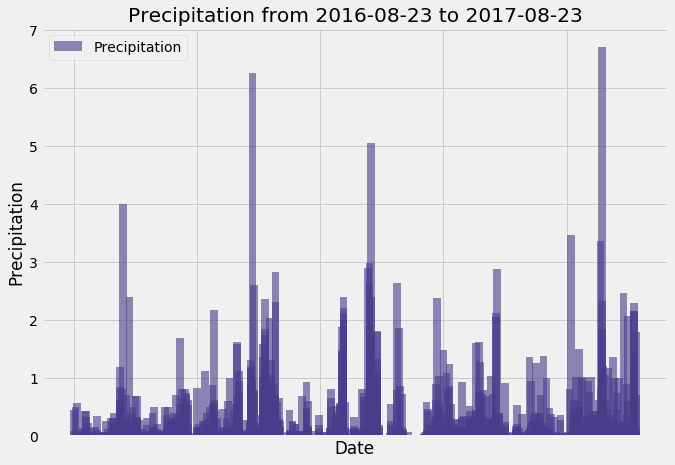

<Figure size 432x288 with 0 Axes>

In [23]:
# Plot the Data using MATPLOTLIB
# Create a bar chart to display the amount of rain over a year

XA = RainFrame.index.tolist()
YA = RainFrame['Precipitation'].tolist()
plt.figure(figsize=(10,7))
plt.bar(XA,YA, width = 5 ,color='darkslateblue', alpha=0.6, align="center",label='Precipitation')

# Remove ticks from X-Axis due to obvious constraints of not being able to have 365 ticks
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
MajTicks = np.arange(0,400,80)
plt.xticks(MajTicks)

# Set plot labels
plt.title(f"Precipitation from 2016-08-23 to {Last[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()
plt.savefig('purplerain.png')

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
RainFrame.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset? 
# Use ID for query as ID is Primary Key HeheHoho
session.query(Station.id).count()

9

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Stati = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).all()
Stati

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded 
# highest temperature recorded, and average temperature of the most active station?
# Use fun.min/max/avg and query from 'tobs'

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == "USC00519281").all() #from 'station' filter the most active id from above

[(54.0, 85.0, 71.66378066378067)]

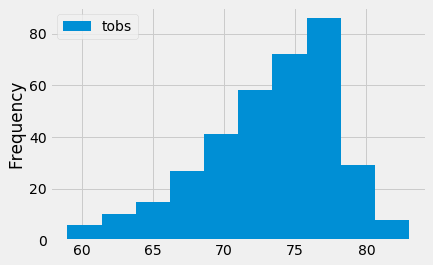

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Create a list to hold data. Query from tobs and filter as above with most active station over a span
# of 12 months.

TList = []
MaxTemp = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= '2016-08-23')
TDF = pd.DataFrame(MaxTemp, columns=['tobs'])
TDF.plot.hist();

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
StartDate = '2016-08-23'
EndDate = '2017-08-23'
MathTemp = calc_temps(StartDate, EndDate)[0]
MathTemp

(58.0, 74.59058295964125, 87.0)

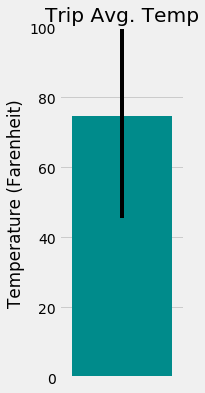

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x = [0]
y = [MathTemp[1]]
Er = [(MathTemp[2] - MathTemp[0])]
plt.figure(figsize=(2,6))
plt.title('Trip Avg. Temp')
plt.bar(x, y, color='darkcyan', yerr=Er)
plt.xlim(-0.50,0.50)
plt.ylabel("Temperature (Farenheit)")
plt.ylim(0,100,50)
plt.tick_params(axis='x',
                which='both', 
                bottom=False, 
                top=False, 
                labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

In [32]:
# Create requested query

StrtDte = '2016-08-23'
EndDte = '2017-08-23'

QRNG = [Station.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.sum(Measurement.prcp)]
QRES = session.query(*QRNG).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= StrtDte).\
    filter(Measurement.date <= EndDte).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()

# Create a simple DF to view the data in a way that won't Homelander our eyes.

StDF = pd.DataFrame(QRES, columns=['Station',
                                   'Name',
                                   'Latitude',
                                   'Longitude',
                                   'Elevation',
                                   'Precipitation'])
StDF
StDF.set_index('Station') 

,Name,Latitude,Longitude,Elevation,Precipitation
Station,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,147.81
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,70.03
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.51
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,38.01
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.24
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.09
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.59
